#### Characterization of the affected tracks by the L train closure

In [2]:
# Standard imports wo wotk with data, graphs, APIs, etc.

# Compatibility with Python 3
from __future__ import print_function, division

import pylab as pl
import pandas as pd
import geopandas as gpd
import numpy as np
import os
import json
import requests
import urllib2
import urllib
import ast
from cStringIO import StringIO
#from get_jsonparsed_data import get_jsonparsed_data
from pandas.tools.plotting import scatter_matrix
import statsmodels.api as sm
import statsmodels.formula.api as smf
import scipy.stats as stats
from scipy.interpolate import *
from sklearn.cluster import KMeans
from scipy.cluster.vq import whiten
import zipfile
from geopandas import GeoDataFrame
import pysal as ps
from fiona.crs import from_epsg
import matplotlib.colors as mcolors
import operator
from matplotlib.colors import ListedColormap    
from IPython.display import Image
from IPython.core.display import HTML


# Horrible pandas plot bug
# http://stackoverflow.com/questions/33995707/attributeerror-unknown-property-color-cycle
#matplotlib.style.use('ggplot')

#loading rcParams from JSON template (created from Federica's fbb_matplotlibrc.json)
url = 'https://s3.amazonaws.com/sb-public/sbg389_matplotlibrc.json'
resp = requests.get(url=url)
data = json.loads(resp.text)
# update the rcParams object
pl.rcParams.update(data)

%pylab inline

Populating the interactive namespace from numpy and matplotlib


C:\Program Files\Anaconda2\lib\site-packages\matplotlib\__init__.py:878: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
C:\Program Files\Anaconda2\lib\site-packages\matplotlib\__init__.py:878: UserWarning: svg.embed_char_paths is deprecated and replaced with svg.fonttype; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))
C:\Program Files\Anaconda2\lib\site-packages\IPython\core\magics\pylab.py:161: UserWarning: pylab import has clobbered these variables: ['griddata', 'insert', 'polyint']
`%matplotlib` prevents importing * from pylab and numpy
  "\n`%matplotlib` prevents importing * from pylab and numpy"


In [3]:
# Create helper function to get data from Carto
# Function based on FBB SQL notebook reference

def queryCartoDB(query, format, source):
    """ queries a url with an sql compatible search
    Arguments:
    query : the sql query string
    format : the expected format
    source " the url of the API
    """
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

In [4]:
# This variable will be used on all SQL queries

SQL_SOURCE = 'https://fb55.carto.com/api/v2/sql'

In [5]:
# First census data SQL query: 2010
dec10_query = '''
SELECT geo_id, geo_id2, the_geom, 
hd01_s001 as totalPolulation, 
hd02_s078 as whitePopulationPercentage, 
hd01_s020 as medianAge
FROM dec_10_sf1_sf1dp1
'''

dec10_query = '''
SELECT dec_10_sf1_sf1dp1.geo_id, dec_10_sf1_sf1dp1.geo_id2, dec_10_sf1_sf1dp1.the_geom,
dec_10_sf1_sf1dp1.hd01_s001 as totalPolulation, 
dec_10_sf1_sf1dp1.hd02_s078 as whitePopulationPercentage, 
dec_10_sf1_sf1dp1.hd01_s020 as medianAge,
ACS_10_5YR_S1901_with_ann.HC01_EST_VC13 as medianHouseholdIncome
FROM dec_10_sf1_sf1dp1, ACS_10_5YR_S1901_with_ann
WHERE dec_10_sf1_sf1dp1.geo_id = ACS_10_5YR_S1901_with_ann.geo_id
'''

# Use the queryCartoDB helper function to retreive the decennial census datasets GeoJSON format
# Parse the JSON into a string and load it into a geopandas geodataframe

datastream = queryCartoDB(dec10_query, format='GeoJSON', source=SQL_SOURCE)
datageo  = json.loads(datastream.read())
dec10DF = GeoDataFrame.from_features(datageo['features'])

In [6]:
dec10DF.head()

,geo_id,geo_id2,geometry,medianage,medianhouseholdincome,totalpolulation,whitepopulationpercentage
0,1400000US36001000100,36001000100,None,32.2,32333,2139,23.7
1,1400000US36001000200,36001000200,None,28.8,25354,6046,13.9
2,1400000US36001000300,36001000300,None,35.4,30932,5888,49.9
3,1400000US36001000401,36001000401,None,63.7,60909,2227,86.3
4,1400000US36001000403,36001000403,None,38.3,52807,4415,76.7


In [7]:
# Fifth (and last!) census data SQL query: census tracts 
    
tractsQuery = '''
SELECT *
FROM table_2010_census_tracts
'''

# Use the queryCartoDB helper function to retreive the decennial census datasets GeoJSON format
# Parse the JSON into a string and load it into a geopandas geodataframe
datastream = queryCartoDB(tractsQuery, format='GeoJSON', source=SQL_SOURCE)
datageo  = json.loads(datastream.read())
censusTractDF = GeoDataFrame.from_features(datageo['features'])

In [8]:
# Load the previously isolated affected tracts

fname = 'Data/Reducedtrack.geojson'
reducedTracts = gpd.GeoDataFrame.from_file(fname)



In [9]:
reducedTracts.head()

,Within15min,Within30min,bigManhattanCommute,boro_code,boro_ct_2010,boro_name,cdeligibil,ct_2010,ctlabel,geometry,id,ntacode,ntaname,puma,shape_area,shape_leng
0,1,1,1,3,3028501,Brooklyn,I,028501,285.01,(POLYGON ((-73.93856854782675 40.6988481355494...,114,BK78,Bushwick South,4002,895739.69679,4167.68973824
1,1,1,0,3,3036300,Brooklyn,E,036300,363,(POLYGON ((-73.91400482503951 40.6732394879431...,133,BK79,Ocean Hill,4007,2785736.31011,8445.46688322
2,1,1,1,3,3036502,Brooklyn,E,036502,365.02,(POLYGON ((-73.90267831840295 40.6757897287538...,134,BK79,Ocean Hill,4007,1252061.56461,6132.19606711
3,1,1,0,3,3039700,Brooklyn,E,039700,397,(POLYGON ((-73.91464246723457 40.6875070419845...,137,BK78,Bushwick South,4002,1712820.27346,6560.68169372
4,1,1,1,3,3039900,Brooklyn,E,039900,399,(POLYGON ((-73.92115385566102 40.6927966934759...,138,BK78,Bushwick South,4002,1627809.30279,6391.34887911


In [19]:
# Build the Geo ID that can be used to merge with the census data

countyID = {'Bronx':'005',
           'Manhattan':'061',
           'Staten Island':'085',
           'Brooklyn':'047',
           'Queens':'081'}

reducedTracts['allcodes'] = list(zip(reducedTracts.boro_name, reducedTracts.ct_2010))

reducedTracts['geo_id'] = reducedTracts[['allcodes']].applymap(lambda x:("1400000US36%03d%06d"%(int(countyID[x[0]]),int(x[1]))))

reducedTracts.head()

,Within15min,Within30min,bigManhattanCommute,boro_code,boro_ct_2010,boro_name,cdeligibil,ct_2010,ctlabel,geometry,id,ntacode,ntaname,puma,shape_area,shape_leng,allcodes,geo_id
0,1,1,1,3,3028501,Brooklyn,I,028501,285.01,(POLYGON ((-73.93856854782675 40.6988481355494...,114,BK78,Bushwick South,4002,895739.69679,4167.68973824,"(Brooklyn, 028501)",1400000US36047028501
1,1,1,0,3,3036300,Brooklyn,E,036300,363,(POLYGON ((-73.91400482503951 40.6732394879431...,133,BK79,Ocean Hill,4007,2785736.31011,8445.46688322,"(Brooklyn, 036300)",1400000US36047036300
2,1,1,1,3,3036502,Brooklyn,E,036502,365.02,(POLYGON ((-73.90267831840295 40.6757897287538...,134,BK79,Ocean Hill,4007,1252061.56461,6132.19606711,"(Brooklyn, 036502)",1400000US36047036502
3,1,1,0,3,3039700,Brooklyn,E,039700,397,(POLYGON ((-73.91464246723457 40.6875070419845...,137,BK78,Bushwick South,4002,1712820.27346,6560.68169372,"(Brooklyn, 039700)",1400000US36047039700
4,1,1,1,3,3039900,Brooklyn,E,039900,399,(POLYGON ((-73.92115385566102 40.6927966934759...,138,BK78,Bushwick South,4002,1627809.30279,6391.34887911,"(Brooklyn, 039900)",1400000US36047039900


In [21]:
reducedTractsCharacterized = pd.merge (dec10DF, reducedTracts, on=['geo_id'])

In [22]:
reducedTractsCharacterized.head()

,geo_id,geo_id2,geometry_x,medianage,medianhouseholdincome,totalpolulation,whitepopulationpercentage,Within15min,Within30min,bigManhattanCommute,...,ct_2010,ctlabel,geometry_y,id,ntacode,ntaname,puma,shape_area,shape_leng,allcodes
0,1400000US36047028501,36047028501,None,29.4,59583,428,31.5,1,1,1,...,028501,285.01,(POLYGON ((-73.93856854782675 40.6988481355494...,114,BK78,Bushwick South,4002,895739.69679,4167.68973824,"(Brooklyn, 028501)"
1,1400000US36047028700,36047028700,None,30.3,23025,2991,19.8,1,1,0,...,028700,287,(POLYGON ((-73.93522264436678 40.6969865451317...,1358,BK35,Stuyvesant Heights,4003,1601115.47128,5919.88468136,"(Brooklyn, 028700)"
2,1400000US36047030100,36047030100,None,32.8,41646,2750,6,1,1,0,...,030100,301,(POLYGON ((-73.91630119861492 40.6785771124340...,891,BK79,Ocean Hill,4007,2133891.72942,7471.47949151,"(Brooklyn, 030100)"
3,1400000US36047030300,36047030300,None,28.3,22613,4458,3.7,1,1,0,...,030300,303,(POLYGON ((-73.9136960555289 40.67649567240918...,1383,BK79,Ocean Hill,4007,2690239.58615,6898.56084221,"(Brooklyn, 030300)"
4,1400000US36047036100,36047036100,None,33.7,20288,2608,5.4,1,1,0,...,036100,361,(POLYGON ((-73.91487246337705 40.6705322282206...,1511,BK79,Ocean Hill,4007,1524420.55669,6064.69993597,"(Brooklyn, 036100)"


In [23]:
reducedTractsCharacterized = reducedTractsCharacterized[['geo_id', 'medianage','totalpolulation','whitepopulationpercentage',
                                  'boro_name', 'medianhouseholdincome', 'geometry_y']]

reducedTractsCharacterized = reducedTractsCharacterized[(reducedTractsCharacterized != 0).all(1)]

reducedTractsCharacterized.whitepopulationpercentage =\
pd.to_numeric(reducedTractsCharacterized.whitepopulationpercentage, errors='coerce')

reducedTractsCharacterized.medianage =\
pd.to_numeric(reducedTractsCharacterized.medianage, errors='coerce')

reducedTractsCharacterized.totalpolulation =\
pd.to_numeric(reducedTractsCharacterized.totalpolulation, errors='coerce')

reducedTractsCharacterized.medianhouseholdincome =\
pd.to_numeric(reducedTractsCharacterized.medianhouseholdincome, errors='coerce')

reducedTractsCharacterized = reducedTractsCharacterized.dropna()
reducedTractsCharacterized.head()

,geo_id,medianage,totalpolulation,whitepopulationpercentage,boro_name,medianhouseholdincome,geometry_y
0,1400000US36047028501,29.4,428,31.5,Brooklyn,59583.0,(POLYGON ((-73.93856854782675 40.6988481355494...
1,1400000US36047028700,30.3,2991,19.8,Brooklyn,23025.0,(POLYGON ((-73.93522264436678 40.6969865451317...
2,1400000US36047030100,32.8,2750,6.0,Brooklyn,41646.0,(POLYGON ((-73.91630119861492 40.6785771124340...
3,1400000US36047030300,28.3,4458,3.7,Brooklyn,22613.0,(POLYGON ((-73.9136960555289 40.67649567240918...
4,1400000US36047036100,33.7,2608,5.4,Brooklyn,20288.0,(POLYGON ((-73.91487246337705 40.6705322282206...


In [24]:
# Convert the tempDF to geoDataframe

reducedTractsCharacterized = GeoDataFrame(reducedTractsCharacterized, 
                                          geometry=reducedTractsCharacterized['geometry_y'])

In [49]:
# Get NYC Shape
SQL_SOURCE = 'https://fernando-melchor.carto.com/api/v2/sql'

# functoin to query CartoDB
def queryCartoDB(query, format='CSV', source=SQL_SOURCE):
    data = urllib.urlencode({'format': format, 'q': query})
    try:
        response = urllib2.urlopen(source, data)
    except urllib2.HTTPError, e:
        raise ValueError('\n'.join(ast.literal_eval(e.readline())['error']))
    except Exception:
        raise
    return StringIO(response.read())

NYCshapeQuery = '''
SELECT *
FROM nyc_zip_code
'''
NYCshapeStream = queryCartoDB(NYCshapeQuery, format = 'GeoJSON')
NYCshapeData   = json.loads(NYCshapeStream.read())
NYCshape     = gpd.GeoDataFrame.from_features(NYCshapeData['features'])

#NYCshape.to_crs(epsg = 2263, inplace = True) # from ft2 to mi2 

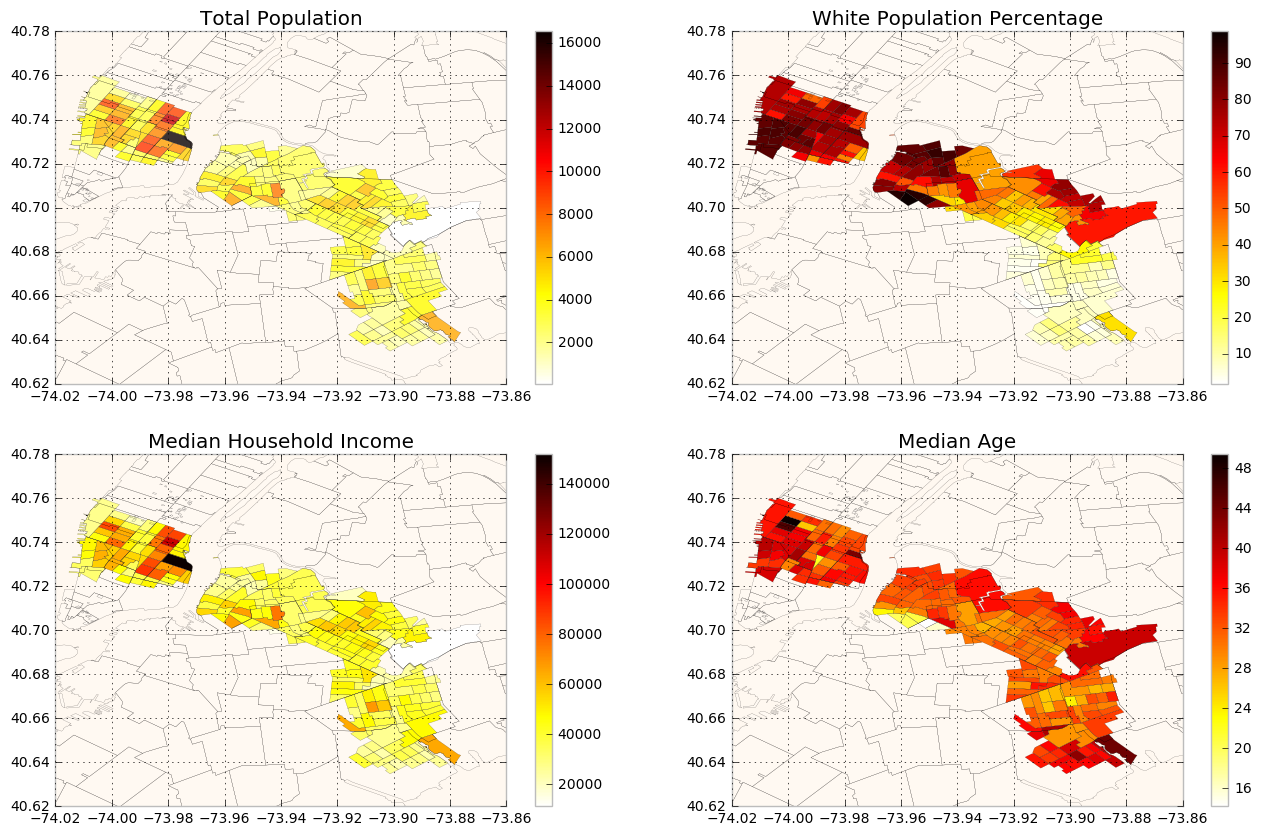

In [58]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(nrows=2, ncols=2,  figsize=(16,10))

reducedTractsCharacterized.plot(column='totalpolulation', cmap='hot_r', alpha=1, linewidth=0.1, ax=ax1)

# Plot 1

ax1.set_ylim(40.62, 40.78)
ax1.set_xlim(-74.02, -73.86)

NYCshape.plot(linewidth = 0.1, color = 'w', ax = ax1,alpha=.2)

ax1.set_title("Total Population")
ax1.set_xlabel('')
ax1.set_ylabel('')

reducedTractsCharacterized['totalpolulation'] = \
pd.to_numeric(reducedTractsCharacterized['totalpolulation'], errors='coerce')

normalize = mcolors.Normalize(vmin=reducedTractsCharacterized['totalpolulation'].min(),
vmax=reducedTractsCharacterized['totalpolulation'].max())
colormap = cm.hot_r
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(reducedTractsCharacterized['totalpolulation'])
pl.colorbar(scalarmappaple, ax=ax1)

#Plot 2

ax2.set_ylim(40.62, 40.78)
ax2.set_xlim(-74.02, -73.86)

NYCshape.plot(linewidth = 0.1, color = 'w', ax = ax2,alpha=.2)



reducedTractsCharacterized.plot(column='whitepopulationpercentage', cmap='hot_r',
                                alpha=1, linewidth=0.1, ax=ax2)

ax2.set_title("White Population Percentage")
ax2.set_xlabel('')
ax2.set_ylabel('')

reducedTractsCharacterized['whitepopulationpercentage'] = \
pd.to_numeric(reducedTractsCharacterized['whitepopulationpercentage'], errors='coerce')

normalize = mcolors.Normalize(vmin=reducedTractsCharacterized['whitepopulationpercentage'].min(),
vmax=reducedTractsCharacterized['whitepopulationpercentage'].max())
colormap = cm.hot_r
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(reducedTractsCharacterized['whitepopulationpercentage'])
pl.colorbar(scalarmappaple, ax=ax2)

# Plot 3

ax3.set_ylim(40.62, 40.78)
ax3.set_xlim(-74.02, -73.86)

NYCshape.plot(linewidth = 0.1, color = 'w', ax = ax3,alpha=.2)


reducedTractsCharacterized.plot(column='totalpolulation', cmap='hot_r',
                                alpha=1, linewidth=0.1, ax=ax3)

ax3.set_title("Median Household Income")
ax3.set_xlabel('')
ax3.set_ylabel('')

reducedTractsCharacterized['medianhouseholdincome'] = \
pd.to_numeric(reducedTractsCharacterized['medianhouseholdincome'], errors='coerce')

normalize = mcolors.Normalize(vmin=reducedTractsCharacterized['medianhouseholdincome'].min(),
vmax=reducedTractsCharacterized['medianhouseholdincome'].max())
colormap = cm.hot_r
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(reducedTractsCharacterized['medianhouseholdincome'])
pl.colorbar(scalarmappaple, ax=ax3)


# Plot 4

ax4.set_ylim(40.62, 40.78)
ax4.set_xlim(-74.02, -73.86)

NYCshape.plot(linewidth = 0.1, color = 'w', ax = ax4,alpha=.2)


reducedTractsCharacterized.plot(column='medianage', cmap='hot_r',
                                alpha=1, linewidth=0.1, ax=ax4)

ax4.set_title("Median Age")
ax4.set_xlabel('')
ax4.set_ylabel('')

reducedTractsCharacterized['medianage'] = \
pd.to_numeric(reducedTractsCharacterized['medianage'], errors='coerce')

normalize = mcolors.Normalize(vmin=reducedTractsCharacterized['medianage'].min(),
vmax=reducedTractsCharacterized['medianage'].max())
colormap = cm.hot_r
scalarmappaple = cm.ScalarMappable(norm=normalize, cmap=colormap)
scalarmappaple.set_array(reducedTractsCharacterized['medianage'])
pl.colorbar(scalarmappaple, ax=ax4)